# 1. Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.stats.stattools

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

# Converting column dtypes

In [4]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year
#df.info()

In [5]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('str')

In [6]:
# lambda function to extract the first character of each object and convert it to an int.
extract_num = lambda x: int(x[:2])

# Apply the lambda function
df['grade'] = df['grade'].apply(extract_num)

In [7]:
condish = {'Poor': 1,'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
df.condition = [condish[item] for item in df.condition]

In [8]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

# Filtering out rows not in King County

In [9]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

#### URL for King County Coordinate info
[King County Coordinates](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [10]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

# Dropping Null, Duplicate, and Unecessary Columns

In [11]:
df_king.drop(['id', 'address', 'date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long'], axis=1, inplace=True)
#df_king.info()

In [12]:
df_king.drop_duplicates(inplace=True)
#df_king.info()

In [13]:
df_king.dropna(inplace=True)
#df_king.info()

# 2. Data Understanding

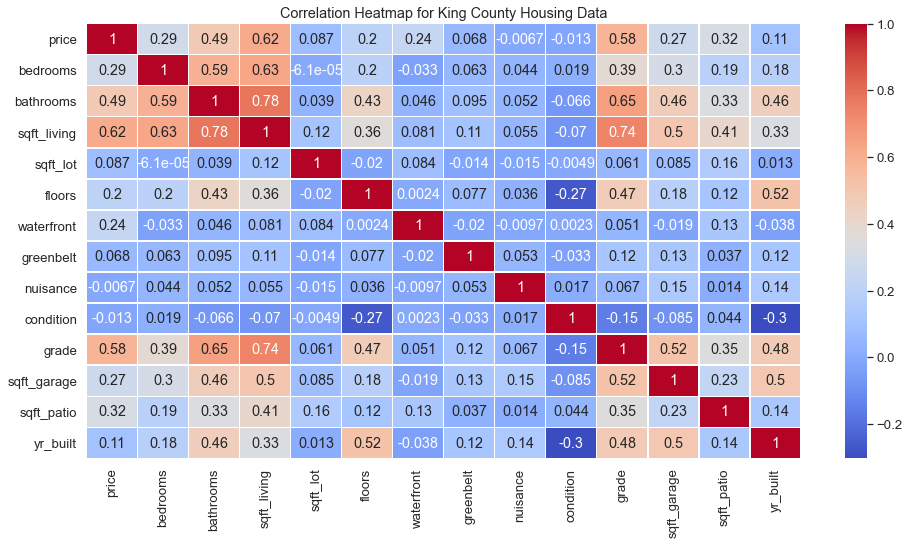

In [13]:
corr_matrix = df_king.corr(method='pearson')

sns.set(font_scale=1.2)
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for King County Housing Data")
plt.show()

# 3. Creating Simple Base Model

### Examining the heatmap, it appears that the Square Feet of Living Space in a home exhibits the strongest correlation coefficient with respect to housing prices. Consequently, using this feature as the basis for a model is logical, as one would intuitively assume that the size of a home, measured in square feet, significantly influences its price.

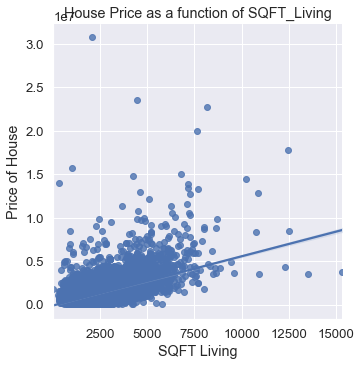

In [14]:
sns.lmplot(data=df_king, x='sqft_living', y='price')
plt.xlabel('SQFT Living')
plt.ylabel('Price of House')
plt.title('House Price as a function of SQFT_Living');

#### Seems to be a clear relationship


In [14]:
#using log to adjust our most correlated feature and price so that we can create a base model with existing outliers
df_king['log_sqft_living'] = np.log(df_king['sqft_living'])
df_king['log_price'] = np.log(df_king['price'])

In [15]:
y = df_king['log_price']
X = df_king['log_sqft_living']

base_model = sm.OLS(y, sm.add_constant(X)).fit()


print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                 1.583e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:02:20   Log-Likelihood:                -19447.
No. Observations:               29160   AIC:                         3.890e+04
Df Residuals:                   29158   BIC:                         3.891e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.8011      0.047    1

#### Assumption Tests and Analysis:
- Passes **multicollinearity** with cond. no. 132 (under 1,000)
- Passes **independence** with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
- Fails **normality** Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
- Slightly skewed left
- 9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

# Assumption Testing 

## I. # Linearity Residual plots

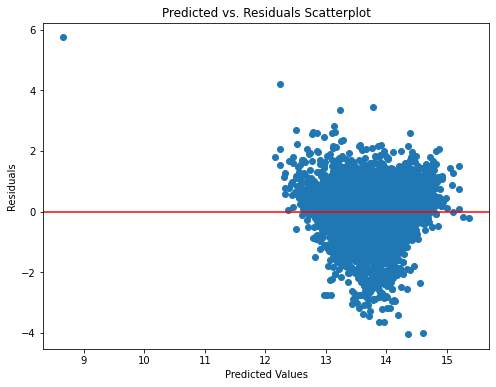

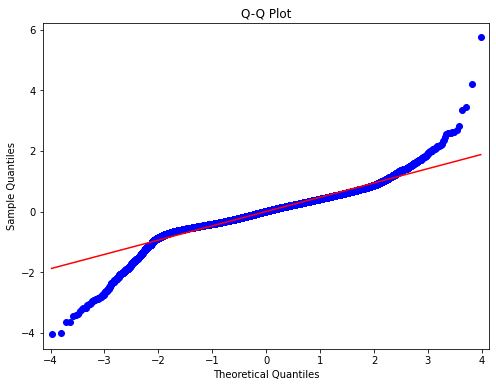

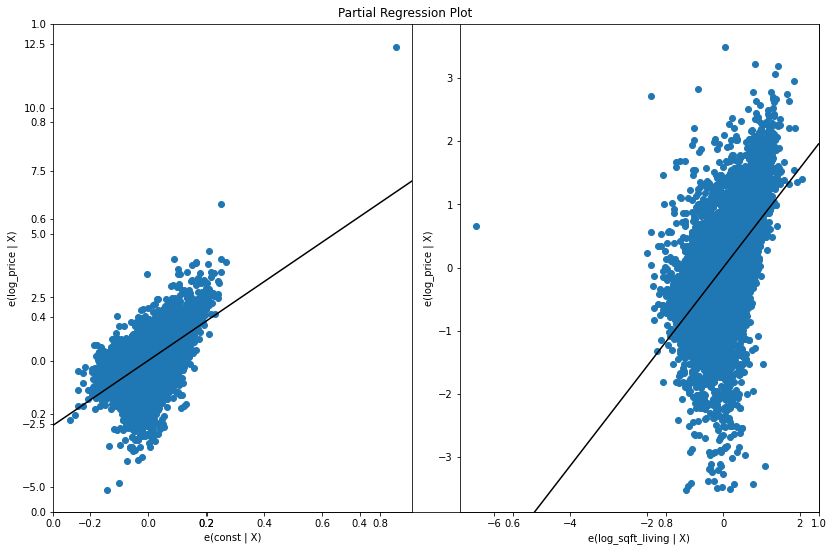

In [16]:
# Residual plots
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(base_model.predict(), base_model.resid)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted vs. Residuals Scatterplot')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Partial regression plots
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.plot_partregress_grid(base_model, fig=fig)
plt.show()

In [17]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(base_model)

(1.002152126688082, 0.44836808497263925)

## Based on our q-q plot and linear rainbow diagnostic we cann assume that our linear regression model has satisfied the Linear Assumptino

## II. **Normality Assumption**: Assumes that residuals or errors are normally distributed.

- The **Omnibus test** is used to detect normality assumption. A low probability value suggests that the distribution of errors or residuals is not normal. In this case, the p-value for the Omnibus test is 0.000 which means that we can reject the null hypothesis of normal distribution of residuals and conclude that the normality assumption is violated.
- **Jarque-Bera** (JB) test is also used to check for normality assumption. The JB test statistic measures whether the data has skewness or kurtosis values matching a normal distribution. If the test statistic is large and/or the p-value is low, then skewness and/or kurtosis are not similar to a normal distribution. With a very large test statistic of 50073454.459 and the p-value of 0.00, we can reject the null hypothesis of normality, indicating a violation of normality assumption.
- **Skewness** measures the degree of asymmetry of a probability distribution. A symmetrical distribution will have a skewness of 0. Positive skewness means there are more observations on the left side of the distribution, while negative means more observations on the right side. Here, the skewness value of 8.237 indicates positive skewness.
- **Kurtosis** measures the degree of peakness of a probability distribution. A normal distribution has a kurtosis of 3, and if it is greater than 3, it is said to be leptokurtic or heavy-tailed, and if it is less than 3, it is said to be platykurtic or light-tailed. The value of Kurtosis here is exceptionally high at 205.252 reflecting a severe deviation from normality.

In [18]:
base_model.summary().tables[2]

Omnibus:,4713.705,Durbin-Watson:,1.998
Prob(Omnibus):,0.000,Jarque-Bera (JB):,46025.485
Skew:,-0.482,Prob(JB):,0.00
Kurtosis:,9.079,Cond. No.,132.


#### with omnibus and Jarque-Bera having small p-values this suggests that we cannot reject the null-hypothesis that the base model data is normally distributed.
#### Also with a Kurtosis greater than 3 this would suggest that the distribution is heavilyt tailed/spread out
#### Therefore this model does not pass normality assumption and we can not assume that this model is normally distributed

## III.Homoscedasticity Assumption: Assumes that the variance of residuals is constant across observations or independent variable values.
- need to look into this

In [19]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [20]:
het_breuschpagan(base_model.resid, sm.add_constant(X))

(0.014478435922771205,
 0.9042246136359329,
 0.014477450077156569,
 0.9042286877075965)

#### larger p-values for Lagrange Multiplier and Breuschpagan suggest that this base model passes Homoscedasticity Assumption

# IV. Independence

In [21]:
resids = base_model.resid 
dw = sm.stats.stattools.durbin_watson
dw(resids)

1.9984069016801884

#### A score of almost 2 indicates that there is no autocorrelation and therefore passess the independence assumption

# 4. Testing multiple regression models

In [22]:
df_king.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29160 entries, 0 to 30154
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            29160 non-null  float64
 1   bedrooms         29160 non-null  int64  
 2   bathrooms        29160 non-null  float64
 3   sqft_living      29160 non-null  int64  
 4   sqft_lot         29160 non-null  int64  
 5   floors           29160 non-null  float64
 6   waterfront       29160 non-null  int64  
 7   greenbelt        29160 non-null  int64  
 8   nuisance         29160 non-null  int64  
 9   condition        29160 non-null  int64  
 10  grade            29160 non-null  int64  
 11  heat_source      29160 non-null  object 
 12  sewer_system     29160 non-null  object 
 13  sqft_garage      29160 non-null  int64  
 14  sqft_patio       29160 non-null  int64  
 15  yr_built         29160 non-null  int64  
 16  zipcode          29160 non-null  object 
 17  log_sqft_liv

### I. One-Hot encoding categorical data to see if any sub category has a stronger correlation with price than current variables (these categorical columns were not on scale like 'grade' and 'condition' and the boolean categories)
#### Categorical columns:
- zipcode
- heat_source
- sewer_system

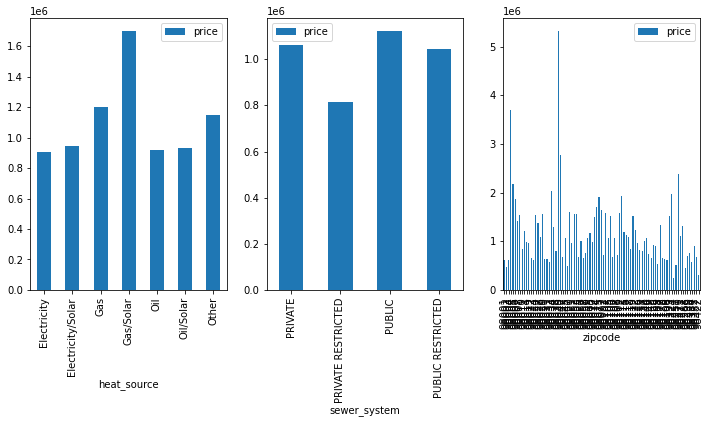

In [23]:
import matplotlib.pyplot as plt

categorical_features = df_king.select_dtypes("object").columns
fig, axes = plt.subplots(ncols=len(categorical_features), figsize=(12,5))

for index, feature in enumerate(categorical_features):
    df_king.groupby(feature).mean().plot.bar(
        y="price", ax=axes[index])

#### A. Zipcodes

In [24]:
df_dummy_zip = df_king.copy()

In [25]:
# Get unique zipcodes
unique_zipcodes = df_dummy_zip['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip = pd.get_dummies(df_dummy_zip, columns=['zipcode'], prefix='zipcode')

# Create a list of new dummy zipcode columns
zip_col = [f"zipcode_{zipcode}" for zipcode in unique_zipcodes]

# Define the most correlated column
most_correlated = 'log_sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated = df_zip[[most_correlated] + zip_col]

In [26]:
df_dummy_zip['zipcode'].value_counts()

98042    992
98038    857
98115    758
98103    757
98117    743
        ... 
98338      2
98387      1
98296      1
98270      1
98422      1
Name: zipcode, Length: 87, dtype: int64

In [27]:
X_iterated.corr()['log_sqft_living'].sort_values(ascending=False)

log_sqft_living    1.000000
zipcode_98075      0.121649
zipcode_98040      0.114481
zipcode_98004      0.108555
zipcode_98006      0.096372
                     ...   
zipcode_98126     -0.073051
zipcode_98133     -0.077607
zipcode_98168     -0.080427
zipcode_98103     -0.084956
zipcode_98106     -0.097303
Name: log_sqft_living, Length: 88, dtype: float64

In [28]:
zip_dummy_base = X_iterated.drop('zipcode_98042', axis=1)

#### B. Heat_Source

In [29]:
df_dummy_heat = df_king.copy()

In [30]:
# Get unique zipcodes
heat_systems = df_dummy_heat['heat_source'].unique()

# Convert column 'zipcode' into dummy columns
df_heat = pd.get_dummies(df_dummy_heat, columns=['heat_source'], prefix='heat_source')

# Create a list of new dummy zipcode columns
heat_col = [f"heat_source_{heat_source}" for heat_source in heat_systems]

# Define the most correlated column
most_correlated2 = 'log_sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated2 = df_heat[[most_correlated2] + heat_col]

In [31]:
df_dummy_heat['heat_source'].value_counts()

Gas                  20159
Electricity           5929
Oil                   2898
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [32]:
X_iterated2.corr()['log_sqft_living'].sort_values(ascending=False)

log_sqft_living                  1.000000
heat_source_Gas                  0.296353
heat_source_Gas/Solar            0.028513
heat_source_Oil/Solar           -0.002567
heat_source_Electricity/Solar   -0.005679
heat_source_Other               -0.008450
heat_source_Oil                 -0.157782
heat_source_Electricity         -0.225606
Name: log_sqft_living, dtype: float64

In [33]:
heat_dum_base = X_iterated2.drop('heat_source_Gas', axis=1)

#### C. sewer_system

In [34]:
df_dummy_sewer = df_king.copy()

In [35]:
# Get unique zipcodes
sewer_systems = df_dummy_sewer['sewer_system'].unique()

# Convert column 'zipcode' into dummy columns
df_sewer = pd.get_dummies(df_dummy_sewer, columns=['sewer_system'], prefix='sewer_system')

# Create a list of new dummy zipcode columns
zip_col3 = [f"sewer_system_{sewer_system}" for sewer_system in sewer_systems]

# Define the most correlated column
most_correlated3 = 'log_sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated3 = df_sewer[[most_correlated3] + zip_col3]

In [36]:
df_dummy_sewer['sewer_system'].value_counts()

PUBLIC                24820
PRIVATE                4333
PRIVATE RESTRICTED        5
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

In [37]:
X_iterated3.corr()['log_sqft_living'].sort_values(ascending=False)

log_sqft_living                    1.000000
sewer_system_PRIVATE               0.040745
sewer_system_PUBLIC RESTRICTED     0.004587
sewer_system_PRIVATE RESTRICTED   -0.017546
sewer_system_PUBLIC               -0.040179
Name: log_sqft_living, dtype: float64

In [38]:
sewer_dum_base = X_iterated3.drop('sewer_system_PUBLIC', axis=1)

In [39]:
iterated_model = sm.OLS(y, sm.add_constant(heat_dum_base))
iterated_results = iterated_model.fit()


In [40]:
print(iterated_results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     2271.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:02:26   Log-Likelihood:                -19426.
No. Observations:               29160   AIC:                         3.887e+04
Df Residuals:                   29152   BIC:                         3.893e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [41]:
iterated_model2 = sm.OLS(y, sm.add_constant(zip_dummy_base))
iterated_results2 = iterated_model2.fit()
print(iterated_results2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     617.5
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:02:27   Log-Likelihood:                -10512.
No. Observations:               29160   AIC:                         2.120e+04
Df Residuals:                   29072   BIC:                         2.193e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.5095      0.040    2

Assumption Tests and Analysis:
Fails multicollinearity with cond. no. higher than 1000 (may be able to pass after removing outliers)
Passes independence with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
Fails normality Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
Slightly skewed left
9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

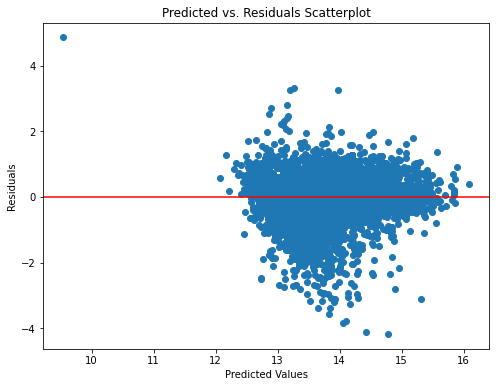

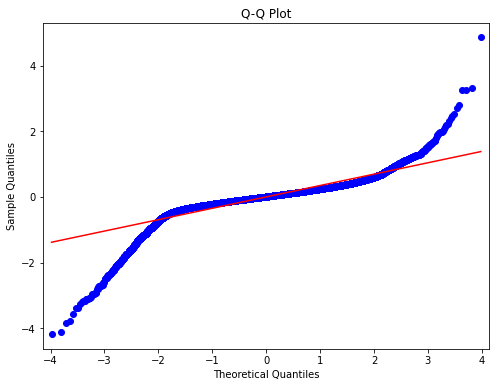

TypeError: 'RegressionResultsWrapper' object is not subscriptable

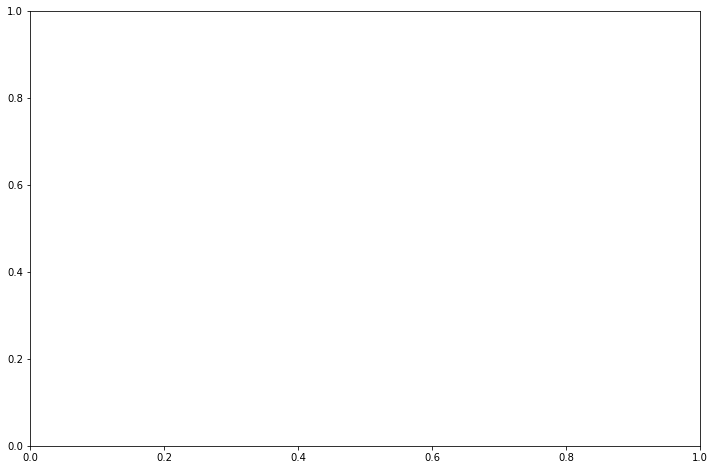

In [44]:
# Residual plots
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(iterated_results2.predict(), iterated_results2.resid)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted vs. Residuals Scatterplot')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(iterated_results2.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Partial regression plots
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.plot_partregress_grid(iterated_results2[10], fig=fig)
plt.show()

## Outlier Detection with box plots

### (only real outliers contained in price. Rest of the entries have outliers but price holds the most and after removing all outliers we are left with a dataframe of nearly 26k entries. 

In [ ]:
sns.lmplot(data=df_king, x='log_sqft_living', y='price')
plt.xlabel('SQFT Living')
plt.ylabel('Price of House')
plt.title('House Price as a function of SQFT_Living');

In [ ]:
df_king.boxplot(column=['price'])

plt.show()

In [ ]:
df_king2 = df_king[(df_king['price'] >= 800000) & (df_king['price'] <= 850000)]
#df_king_price.info()

In [ ]:
#df_king_price =df_king[df_king['price'] <= 1000000]
#df_king_price.info()

In [ ]:
#df_king1 = df_king[df_king['sqft_living'] <= 9000]
#df_king1.info()

In [ ]:
#df_king2 = df_king1[df_king1['sqft_above'] <= 9000]
#df_king2.info()

In [ ]:
#df_king3 = df_king2[df_king2['sqft_patio'] <= 2000]
#df_king3.info()

In [ ]:
#df_king4 = df_king3[df_king3['sqft_garage'] <= 2000]
#df_king4.info()

In [ ]:
#df_king5 = df_king4[df_king4['sqft_basement'] <= 2000]
#df_king5.info()

In [ ]:
#df_king_county = df_king5[df_king5['price'] <= 1882000]
#df_king_county.info()

In [ ]:
#df_king_county.boxplot(column=['price'])

#plt.show()

#### (Keeping the following code for view, heat_source, and sewer_system until we get a better idea of what we want to do with them but for now it seems like they have little correlation with price)

In [ ]:
#one-hot encoding heat source
#heat = {'heat_source': ['Gas', 'Electricity', 'Oil', 'Gas/Solar',
#                        'Electricity/Solar', 'Other', 'Oil/Solar']}

# One-Hot Encoding 'heat_source' column
#df_encoded_heat = pd.get_dummies(df, columns=['heat_source'])

#df_encoded_heat.info()

In [ ]:
#one-hot encoding sewer_system
#sewer = {'sewer_system': ['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED']}

# One-Hot Encoding 'heat_source' column
#df_encoded_sew = pd.get_dummies(df, columns=['sewer'])

#df_encoded_heat.info()

# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


### Condition Column info:

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Grade Column Info:

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.